In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

###  Event stamps ( array I )

-   1   = Rt lever response in FR (if FR greater than 1 otherwise see codes 8,9,17,18,21,22)
-   2   = Lt lever response (if FR greater than 1 otherwise see codes 8,9,17,18,21,22)
#### 3   = Rewarded rt lever response
#### 4   = Rewarded lt lever response
#### 5   = Reinforcement delivery
-   6   = Time-out, no initial head-entry in 10 sec   **** REMOVED FOR VERSION 22_BERNSTEIN ** REINSTATED VERSION 23
-   7   = Time-out, no lever response choice in 10 sec
-   8   = Lever choice right
-   9   = Lever choice left
#### 10  = Initial head entry in trial   **** IN VERSION 22_BERNSTEIN THIS IS SIMULATED AFTER 1 SECOND ** VERSION 23 REINSTATED
#### 11  = Subsequent head entries
-   12  = Right lever press during time-out
-   13  = Left lever press during time-out
-   14  = Head entry during time-out
-   15  = Time-out over
#### 16  = ITI over
#### 17  = Initial forced trial lever press right
#### 18  = Initial forced trial lever press left
-   19  = Time-out, no right lever response forced in 10 seconds
-   20  = Time-out, no left lever response forced in 10 seconds
#### 21  = Forced trial right lever
#### 22  = Forced trail left lever
#### 23  = Choice trial
-   24  = Head entry during ITI
-   25  = ICS signal
-   26  = Extinction trial
-   27  = Time-out, no press in A(22) minutes
-   28  = Time-out, did not complete FR in A(21) minutes
-   100 = Session termination


Use os module to create list of data folders

In [5]:
path_1 = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/LP_train'

session_list_1 = os.listdir(path_1)
print(len(session_list_1))
session_list_1[0:5]

100


['LPtrain_1_681_190607',
 'LPtrain_1_682_190607',
 'LPtrain_1_683_190607',
 'LPtrain_1_684_190607',
 'LPtrain_1_685_190607']

In [6]:
file_paths = []
for file in session_list_1:
    file_path = path_1 + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0:5]

100


['C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/LP_train/LPtrain_1_681_190607',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/LP_train/LPtrain_1_682_190607',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/LP_train/LPtrain_1_683_190607',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/LP_train/LPtrain_1_684_190607',
 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Behavior/Med boxes/probability_discounting/LP_train/LPtrain_1_685_190607']

In [25]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session and session number, saves each accordingly
    import re
    
    path_split = file_path_name.split('/')
    file_split = path_split[-1].split('_')
    
    for row in file_split:
        if re.search(r'^\d\d\d\d\d\d$', row):
            date = row
        if re.search(r'^\d\d\d$', row):
            animal_number = row
        if re.search(r'^\D\D', row):
            session = row
        if re.search(r'^\d$', row):
            session_num = row
        
    session = str(session + '_' + session_num)

    return date, animal_number, session

In [8]:
def make_array_from_path (file_path_name):
    # takes in path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [9]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(str(event_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        if re.search(str(time_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [10]:
def get_trial_times_two(events_and_times, start_marker, end_marker):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for ITI mark of trial segment
    #e.g. conditioned stimulus onset and offset, ITI onset and offset
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    trial_starts = events_and_times[events_and_times['event_stamp'] == start_marker]['time_stamp'].values
    trial_ends = events_and_times[events_and_times['event_stamp'] == end_marker]['time_stamp'].values
    
    times = pd.DataFrame(data = [trial_starts, trial_ends])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

In [11]:
def create_trials_df(events_and_times, trial_times):
    
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
        data['trial_#'] = [i+1]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [12]:
def count(trial_data, bit):
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == bit]))
        i = i + 1
    
    return count

In [13]:
def latency(trial_data, bit):
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == bit]
        if len(data) < 1:
            latency_1st.append(0.0)
            latency_ave.append(0.0)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
            latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [14]:
def HE_wait(trial_data):
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    HE_waits = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        
        count.append(len(data[data['event_stamp'] == bit]))
        i = i + 1
    
    return count

In [36]:
def create_session_df(trial_data, bit_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get HE_wait times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T
    
    i = 0
    HE_waits = []
    while i < times_df.shape[0]:
        if (i == 0) | (i == times_df.shape[0] - 1):
            HE_waits.append(np.nan)
            i += 1
        else:
            HE_wait = times_df.iloc[i]['trial_start'] - times_df.iloc[i-1]['trial_end']
            HE_waits.append(int(HE_wait/100))
            i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, bit in bit_dic.items():
        session_data[str(name + '_count')] = count(trial_data, bit)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave_bit')] = latency(trial_data, bit)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['HE_wait'] = HE_waits
    
    return session_data

In [ ]:
file_path = file_paths[-5]
print('file_path:', '\n', file_path, '\n')

date, animal_number, session, session_num = get_file_info(file_path)
print('date:', date, 'animal_number:', animal_number, 'session:', session, 'session_num:', session_num, '\n')

array = make_array_from_path(file_path)
print(array)

events_and_times = get_events_and_times(array, "I", "T")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_two(events_and_times, 10, 16)
print(trial_times.head(), '\n')

trial_data = create_trials_df(events_and_times, trial_times)
print(trial_data.head(), '\n')

bit_dic = {'reinforcement': 5, 'left_lever': 8, 'right_lever': 9, 'HE_trial': 11, 'HE_ITI': 24}
session_data = create_session_df(trial_data, bit_dic)

In [37]:
%%time
final_data = pd.DataFrame()
bit_dic = {'reinforcement': 5, 'left_lever': 8, 'right_lever': 9, 'HE_trial': 11, 'HE_ITI': 24}

for file in file_paths:
    date, animal_number, session = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "I", "T")
    trial_times = get_trial_times_two(events_and_times, 10, 16)
    trial_data = create_trials_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal_number'] = [animal_number]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    #session_data['session_num'] = [session_num]*(session_data.shape[0])
    
    final_data = pd.concat([final_data, session_data], axis = 0, ignore_index=True)

Wall time: 2min 58s


In [31]:
final_data['session'].value_counts()

LPtrain_4    454
Shape_1      396
LPtrain_5    362
LPtrain_3    260
LPtrain_1     31
LPtrain_2     15
Name: session, dtype: int64

In [44]:
final_data[final_data['session'] == 'Shape_1'].groupby(['session', 'animal_number']).mean().mean()

reinforcement_count               0.991809
reinforcement_latency_1st         5.558843
reinforcement_latency_ave_bit     5.754272
left_lever_count                  0.518542
left_lever_latency_1st            3.094470
left_lever_latency_ave_bit        3.094470
right_lever_count                 0.473267
right_lever_latency_1st           2.454577
right_lever_latency_ave_bit       2.650006
HE_trial_count                    1.024852
HE_trial_latency_1st              0.644506
HE_trial_latency_ave_bit          1.237637
HE_ITI_count                      2.572916
HE_ITI_latency_1st                7.551320
HE_ITI_latency_ave_bit           10.979570
trial_num                        24.250000
HE_wait                          26.931035
dtype: float64

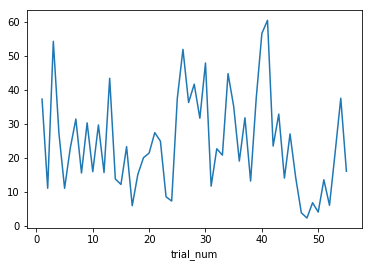

In [49]:
final_data[final_data['session'] == 'Shape_1'].groupby('trial_num')['HE_wait'].mean().plot()

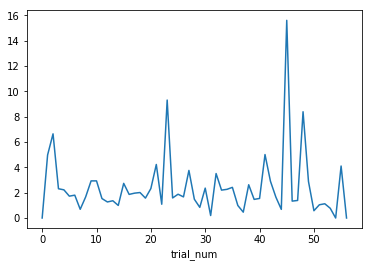

In [51]:
final_data[final_data['session'] == 'Shape_1'].groupby('trial_num')['right_lever_latency_1st'].mean().plot()